In [35]:
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [36]:
loans = joblib.load("../data/final_model_data.joblib")

# import pandas as pd
#
# # Convert the issue_d column to a datetime object
# loans['issue_d'] = pd.to_datetime(loans['issue_d'])
#
# # Create a boolean mask for rows with issue_d in 2018
# mask = loans['issue_d'].dt.year == 2018
#
# # Filter the data using the mask
# loans = loans[mask]

loans = loans.head(10000)

In [37]:
loans.shape

(10000, 71)

In [38]:
train, test = train_test_split(loans, test_size=0.2, shuffle=False)
train, test = train.copy(), test.copy()
print(f"The test set contains {len(test):,} loans.")

The test set contains 2,000 loans.


In [39]:
onehot_cols = ["term", "application_type", "home_ownership", "purpose"]
ordinal_cols = {
    "emp_length": [
        "< 1 year",
        "1 year",
        "2 years",
        "3 years",
        "4 years",
        "5 years",
        "6 years",
        "7 years",
        "8 years",
        "9 years",
        "10+ years",
    ],
}

In [40]:
def run_pipeline_cv_nn(
    data,
    onehot_cols,
    ordinal_cols,
    batch_size,
):
    X = data.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
    y = data["grade_encoded"]

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary", handle_unknown="error")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        print(X_train.keys())
        X_train = transformer.fit_transform(X_train)
        X_valid = transformer.transform(X_valid)

        input_nodes = X_train.shape[1]

        # Define the model architecture
        model = Sequential()
        model.add(Input(shape=input_nodes))
        model.add(Dense(64, activation="relu"))
        model.add(Dropout(0.3, seed=0))
        model.add(Dense(32, activation="relu"))
        model.add(Dropout(0.3, seed=1))
        model.add(Dense(16, activation="relu"))
        model.add(Dropout(0.3, seed=2))
        model.add(Dense(7, activation="softmax"))
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        # Define the EarlyStopping callback
        early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        history = model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=100,
            validation_data=(X_valid, y_valid),
            verbose=2,
            callbacks=[early_stopping],  # Add the EarlyStopping callback
        )

        history_list.append(history.history)
        model_list.append(model)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list


In [41]:
# Encode loan grades as integers
grade_encoder = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
}
train["grade_encoded"] = train["grade"].apply(lambda x: grade_encoder[x])
test["grade_encoded"] = test["grade"].apply(lambda x: grade_encoder[x])

# Run the pipeline with cross-validation
nn_history_list, nn_model_list, nn_transformer_list = run_pipeline_cv_nn(
    train,
    onehot_cols,
    ordinal_cols,
    batch_size=128,
)

Index(['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc',
       'purpose', 'dti', 'delinq_2yrs', 'cr_hist_age_mths', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'inv_mths_since_last_delinq',
       'inv_mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'inv_mths_since_last_major_derog', 'application_type',
       'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'inv_mo_sin_rcnt_rev_tl_op', 'inv_mo_sin_rcnt_tl', 'mort_acc',
       'inv_mths_since_recent_bc', 'inv_mths_since_recent_bc_dlq',
       'inv_mths_since_recent_inq', 'inv_mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       '

In [42]:
def run_pipeline_cv_svm(
    data,
    onehot_cols,
    ordinal_cols,
):
    X = data.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
    y = data["grade_encoded"]

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary", handle_unknown="error")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        print("before trans: ")
        print(X_train.shape)
        print(X_valid.shape)
        X_train = transformer.fit_transform(X_train)
        X_valid = transformer.transform(X_valid)

        print("after trans: ")
        print(X_train.shape)
        print(X_valid.shape)

        # Define the parameter grid to search
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': [0.01, 0.1, 1]
        }

        # Define the SVM model
        svm = SVC(kernel='linear')

        # Use GridSearchCV to search for the best hyperparameters
        grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Print the best hyperparameters and their corresponding score
        print("Best hyperparameters:", grid_search.best_params_)
        print("Best score:", grid_search.best_score_)

        history_list.append(None)
        model_list.append(grid_search.best_estimator_)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list

In [43]:
# Run the pipeline with cross-validation
svm_history_list, svm_model_list, svm_transformer_list = run_pipeline_cv_svm(
    train,
    onehot_cols,
    ordinal_cols,
)

before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.7753125
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.77515625
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.780625
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.775625
before trans: 
(6400, 65)
(1600, 65)
after trans: 
(6400, 79)
(1600, 79)
Best hyperparameters: {'C': 1, 'gamma': 0.01}
Best score: 0.77359375


In [44]:
def run_pipeline_cv_rf(data, onehot_cols, ordinal_cols):
    X = data.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
    y = data["grade_encoded"]

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary", handle_unknown="error")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
    }

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = transformer.fit_transform(X_train)
        X_valid = transformer.transform(X_valid)

        # Define the model architecture
        model = RandomForestClassifier(random_state=0)

        # Use GridSearchCV to search over a grid of hyperparameters
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Evaluate the model
        y_pred = grid_search.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        print(f"Accuracy on validation set: {accuracy:.4f}")

        history_list.append({"accuracy": accuracy})
        model_list.append(grid_search)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list

In [45]:
# Run the pipeline with cross-validation
rf_history_list, rf_model_list, rf_transformer_list = run_pipeline_cv_rf(
    train,
    onehot_cols,
    ordinal_cols,
)

Accuracy on validation set: 0.6644
Accuracy on validation set: 0.6750
Accuracy on validation set: 0.6656
Accuracy on validation set: 0.6481
Accuracy on validation set: 0.6569


In [46]:
# Load the test set and extract the true labels
X_test = test.drop(columns=["issue_d", "date", "grade", "grade_encoded", "sub_grade", "recovered_percentage", "expected_return"])
y_test = test["grade_encoded"]

# Make predictions using the ensemble model
predictions_list_nn = []
predictions_list = []

for i in range(len(nn_model_list)):
    transformer = nn_transformer_list[i]
    model = nn_model_list[i]

    X_test_transformed = transformer.transform(X_test)
    y_pred = model.predict(X_test_transformed)
    predictions_list_nn.append(y_pred)

for i in range(len(svm_model_list)):
    transformer = svm_transformer_list[i]
    model = svm_model_list[i]

    X_test_transformed = transformer.transform(X_test)
    y_pred = model.predict(X_test_transformed)
    predictions_list.append(y_pred)

for i in range(len(rf_model_list)):
    transformer = rf_transformer_list[i]
    model = rf_model_list[i]

    X_test_transformed = transformer.transform(X_test)
    y_pred = model.predict(X_test_transformed)
    predictions_list.append(y_pred)

from scipy.stats import mode

# Convert the predictions to class labels
class_predictions_list = [np.argmax(predictions, axis=1) for predictions in predictions_list_nn]

for predictions in predictions_list:
    class_predictions_list.append(predictions)

# Combine the predictions from each model
class_predictions_array = np.array(class_predictions_list)

# Take the majority vote for each test sample
final_predictions = mode(class_predictions_array, axis=0).mode[0]

# Calculate the accuracy
accuracy = accuracy_score(y_test, final_predictions)

print("Ensemble accuracy:", accuracy)


63/63 [==============================] - 0s 868us/step
Ensemble accuracy: 0.8175


/var/folders/d5/hpc31dsx59l4rfyrs6m6yvp00000gn/T/ipykernel_89623/3564465338.py:45: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions = mode(class_predictions_array, axis=0).mode[0]


In [47]:
# Compute precision, recall, and F1-score of the ensemble model
precision = precision_score(y_test, final_predictions, average="weighted", zero_division=0)
recall = recall_score(y_test, final_predictions, average="weighted", zero_division=0)
f1 = f1_score(y_test, final_predictions, average="weighted", zero_division=0)

print(f"Precision of ensemble model on test set: {precision:.4f}")
print(f"Recall of ensemble model on test set: {recall:.4f}")
print(f"F1-score of ensemble model on test set: {f1:.4f}")

Precision of ensemble model on test set: 0.8153
Recall of ensemble model on test set: 0.8175
F1-score of ensemble model on test set: 0.8148


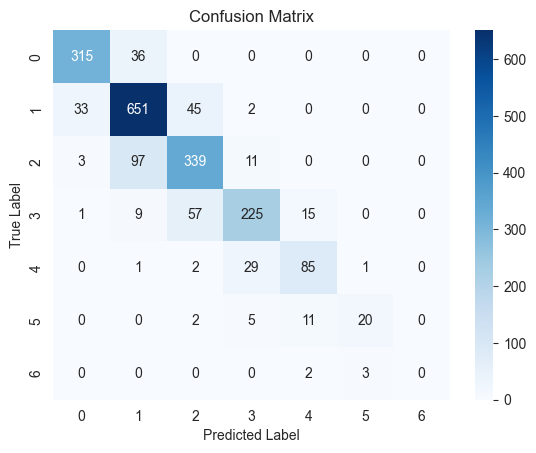

In [48]:
# Compute the confusion matrix of the ensemble model
confusion = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [49]:
# Save the neural network models and data transformers
for i, model in enumerate(nn_model_list):
    model.save(f"nn_loan_grade_model_{i}")
joblib.dump(nn_transformer_list, "nn_classification_transformer.joblib")

# Save the SVM models and data transformers
for i, model in enumerate(svm_model_list):
    joblib.dump(model, f"svm_loan_grade_risk_model_{i}.joblib")
joblib.dump(svm_transformer_list, "svm_classification_transformer.joblib")

# Save the RF models and data transformers
for i, model in enumerate(rf_model_list):
    joblib.dump(model, f"rf_loan_grade_risk_model_{i}.joblib")
joblib.dump(rf_transformer_list, "rf_classification_transformer.joblib")

2023-04-26 17:15:17.823592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-26 17:15:17.842274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-26 17:15:17.860561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-04-26 17:15:18

INFO:tensorflow:Assets written to: nn_loan_grade_model_0/assets


INFO:tensorflow:Assets written to: nn_loan_grade_model_0/assets
2023-04-26 17:15:18.843711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-26 17:15:18.860389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-26 17:15:18.877128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype 

INFO:tensorflow:Assets written to: nn_loan_grade_model_1/assets


INFO:tensorflow:Assets written to: nn_loan_grade_model_1/assets
2023-04-26 17:15:19.773573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-26 17:15:19.789158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-26 17:15:19.804882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype 

INFO:tensorflow:Assets written to: nn_loan_grade_model_2/assets


INFO:tensorflow:Assets written to: nn_loan_grade_model_2/assets
2023-04-26 17:15:20.748726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-26 17:15:20.763148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-26 17:15:20.777257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype 

INFO:tensorflow:Assets written to: nn_loan_grade_model_3/assets


INFO:tensorflow:Assets written to: nn_loan_grade_model_3/assets
2023-04-26 17:15:21.672438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-26 17:15:21.690459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-26 17:15:21.706223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype 

INFO:tensorflow:Assets written to: nn_loan_grade_model_4/assets


INFO:tensorflow:Assets written to: nn_loan_grade_model_4/assets


['rf_classification_transformer.joblib']